## Sokoban analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
games = pd.read_csv('games.csv')
levels = pd.read_csv('levels.csv')

In [3]:
pattern = '|'.join(['kevin', 'mihkel', 'udam', 'elle', 'test'])

games_filtered = games[~games['id_code'].str.contains(pattern, case=False, na=False)]

games_filtered.describe()


,id
count,167.000000
mean,108.203593
std,52.416260
min,2.000000
25%,61.500000
50%,109.000000
75%,154.500000
max,196.000000


In [4]:
filtered_game_ids = games_filtered['id']
levels_filtered = levels[levels['game_id'].isin(filtered_game_ids)]

levels_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 868 entries, 52 to 951
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          868 non-null    int64 
 1   game_id     868 non-null    int64 
 2   level_id    868 non-null    int64 
 3   skipped     868 non-null    object
 4   start_time  868 non-null    object
 5   end_time    720 non-null    object
dtypes: int64(3), object(3)
memory usage: 47.5+ KB


In [5]:
#Remove broken Safari games
game_ids_in_levels = levels_filtered['game_id'].unique()
games_filtered = games_filtered[games_filtered['id'].isin(game_ids_in_levels)]

games_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 20 to 195
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          149 non-null    int64 
 1   id_code     149 non-null    object
 2   token       149 non-null    object
 3   game        149 non-null    object
 4   start_time  149 non-null    object
dtypes: int64(1), object(4)
memory usage: 7.0+ KB


## Results overview

### Level attempts vs successes

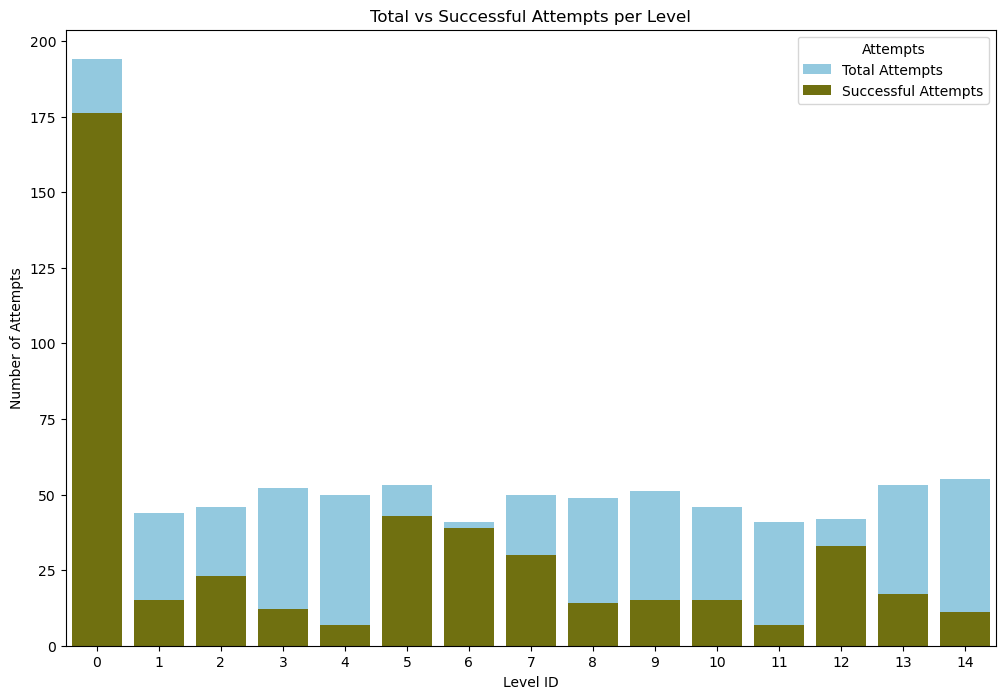

In [6]:
# Count total attempts per level

# drop rows where level_id is 15

levels_filtered = levels_filtered[levels_filtered['level_id'] != 15]
total_attempts = levels_filtered['level_id'].value_counts().reset_index()
total_attempts.columns = ['level_id', 'total_attempts']

# Count how many times the level was passed
passed_attempts = levels_filtered[(~levels_filtered['end_time'].isna()) & (levels_filtered['skipped'] != 't')]['level_id'].value_counts().reset_index()
passed_attempts.columns = ['level_id', 'passed_attempts']

# Merge the two dataframes
df = pd.merge(total_attempts, passed_attempts, on='level_id')

# Calculate success percentage
df['success_percentage'] = df['passed_attempts'] / df['total_attempts'] * 100

# Create a bar plot
plt.figure(figsize=(12,8))
p1 = sns.barplot(data=df, x='level_id', y='total_attempts', color='skyblue', label='Total Attempts')
p2 = sns.barplot(data=df, x='level_id', y='passed_attempts', color='olive', label='Successful Attempts')

plt.legend(title='Attempts')
plt.xlabel('Level ID')
plt.ylabel('Number of Attempts')
plt.title('Total vs Successful Attempts per Level')
plt.show()

## Levels ordered by success rate

[1.1022727272727273, 2.9333333333333336, 2.0, 4.333333333333334, 7.142857142857142, 1.2325581395348837, 1.051282051282051, 1.6666666666666667, 3.5, 3.4, 3.0666666666666664, 5.857142857142857, 1.2727272727272727, 3.1176470588235294, 5.0]


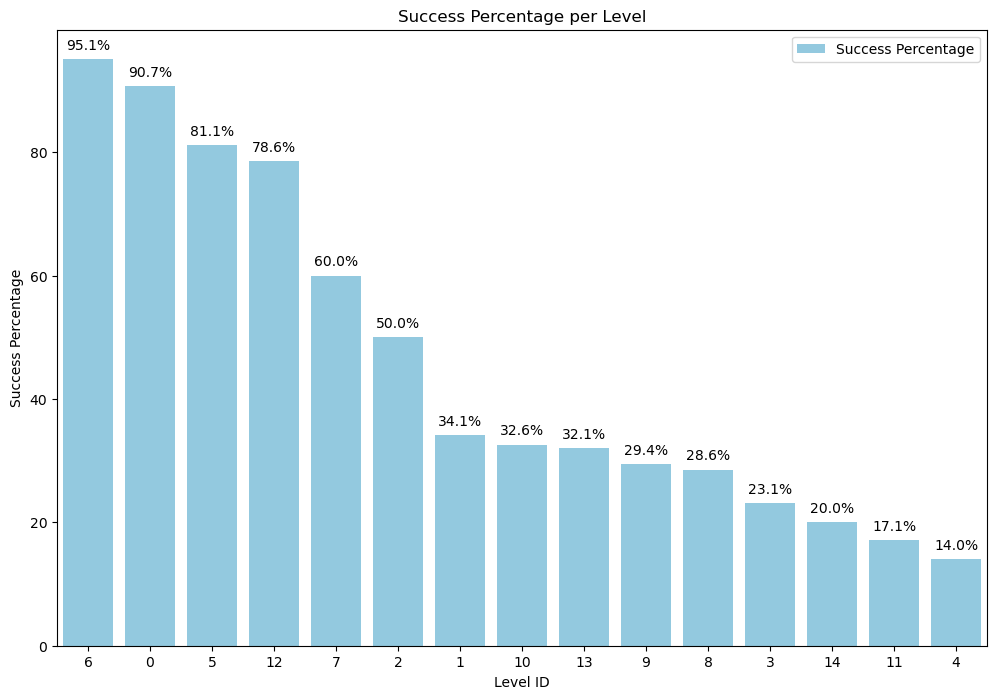

In [7]:

df_per_level = df.sort_values(by='level_id', ascending=True)
level_weights = (1/ (df_per_level['success_percentage'] / 100)).tolist()

print(level_weights)

df['level_id'] = df['level_id'].astype(str)
df = df.sort_values(by='success_percentage', ascending=False)

# Create a bar plot
plt.figure(figsize=(12,8))
p1 = sns.barplot(data=df, x='level_id', y='success_percentage', color='skyblue', label='Success Percentage')

# Add percentage text on top of each bar
for p in p1.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    p1.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.legend()
plt.xlabel('Level ID')
plt.ylabel('Success Percentage')
plt.title('Success Percentage per Level')
plt.show()

## Levels ordered by median time

In [8]:
# Select entries with both end_time and start_time
valid_entries = levels_filtered.dropna(subset=['start_time', 'end_time']).copy()
valid_entries = valid_entries[valid_entries['skipped'] != 't']
valid_entries['level_id'] = valid_entries['level_id'].astype(str)

# Convert end_time and start_time to datetime
valid_entries['end_time'] = pd.to_datetime(valid_entries['end_time'])
valid_entries['start_time'] = pd.to_datetime(valid_entries['start_time'])

# Calculate completion time in seconds
valid_entries.loc[:, 'completion_time'] = (valid_entries['end_time'] - valid_entries['start_time']).dt.total_seconds()
valid_entries = valid_entries[valid_entries['completion_time'] < 1300]

median_times = valid_entries.groupby('level_id')['completion_time'].median().sort_values()

# Order your dataframe according to median_times
valid_entries['level_id'] = pd.Categorical(valid_entries['level_id'], categories=median_times.index, ordered=True)

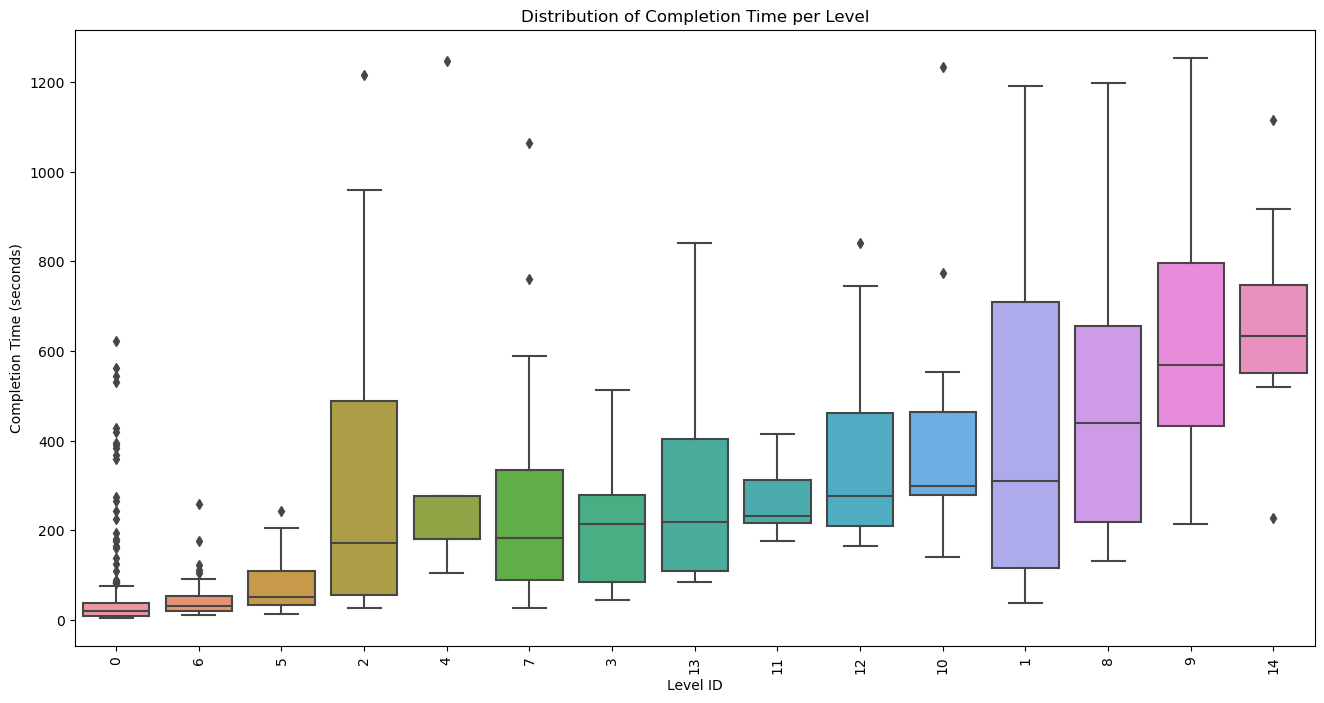

In [9]:
plt.figure(figsize=(16,8))
sns.boxplot(x='level_id', y='completion_time', data=valid_entries)
plt.xlabel('Level ID')
plt.ylabel('Completion Time (seconds)')
plt.title('Distribution of Completion Time per Level')
plt.xticks(rotation=90)  # This rotates the x-axis labels for better visibility if you have many levels
plt.show()

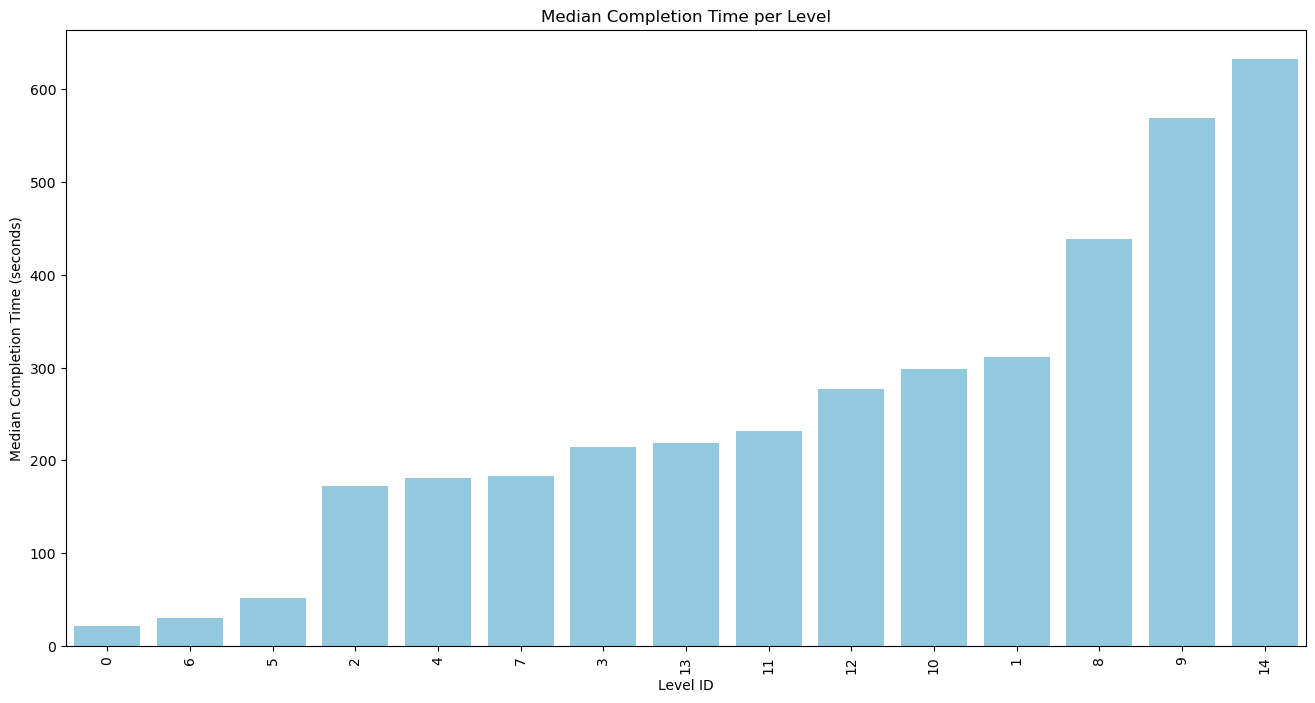

In [10]:
plt.figure(figsize=(16, 8))
sns.barplot(x=median_times.index, y=median_times.values, color='skyblue')
plt.xlabel('Level ID')
plt.ylabel('Median Completion Time (seconds)')
plt.title('Median Completion Time per Level')
plt.xticks(rotation=90)  # This rotates the x-axis labels for better visibility if you have many levels
plt.show()

## Player progression stats

In [11]:
# Filter the dataframe
completed_levels = levels_filtered[(~levels_filtered['start_time'].isna()) & 
                                   (~levels_filtered['end_time'].isna()) & 
                                   (levels_filtered['skipped'] == 'f')]

# Calculate completed levels per game
completed_levels_per_game = completed_levels.groupby('game_id')['level_id'].count()

average_levels = completed_levels_per_game.mean()
median_levels = completed_levels_per_game.median()

print(f"Average completed levels per player: {average_levels}")
print(f"Median completed levels per player: {median_levels}")
print("\n")

print(f"Total number of games: {len(games_filtered)}")
print(f"Number of games with 1 level completed: {len(completed_levels_per_game[completed_levels_per_game == 1])}")
print(f"Number of games with 2 levels completed: {len(completed_levels_per_game[completed_levels_per_game == 2])}")
print(f"Number of games with 3 levels completed: {len(completed_levels_per_game[completed_levels_per_game == 3])}")
print(f"Number of games with at least 4 levels completed: {len(completed_levels_per_game[(completed_levels_per_game >= 4)])}")

print("\n")
print(f"Most successful players and their number of levels completed:\n {completed_levels_per_game.sort_values(ascending=False).head(5)}");

# List all ids of games with 1 levels completed
games_with_1_level = completed_levels_per_game[completed_levels_per_game == 1].index.values

print(games_with_1_level)







Average completed levels per player: 3.1517241379310343
Median completed levels per player: 2.0


Total number of games: 149
Number of games with 1 level completed: 48
Number of games with 2 levels completed: 31
Number of games with 3 levels completed: 21
Number of games with at least 4 levels completed: 45


Most successful players and their number of levels completed:
 game_id
195    16
183    16
189    16
169    14
175    10
Name: level_id, dtype: int64
[ 21  26  29  35  37  40  41  43  44  53  55  64  72  73  75  82  85  89
  96  97  98 104 107 108 109 117 128 133 134 137 138 140 141 142 152 153
 155 156 161 162 170 171 176 180 182 186 192 196]


# Top player level completion times

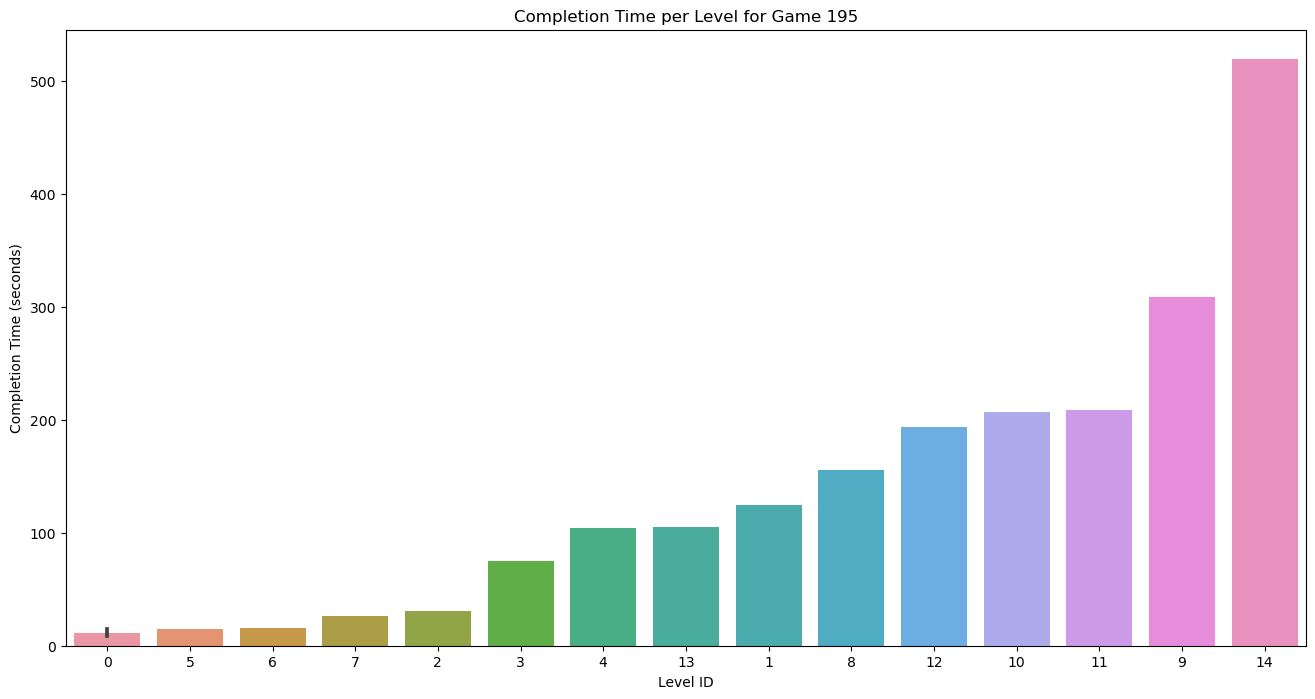

Total time for game 195: 35.21258813333334 minutes


In [12]:
# Player 195

completed_levels = levels_filtered.dropna(subset=['start_time', 'end_time']).copy()
completed_levels = completed_levels[completed_levels['skipped'] != 't']
completed_levels['level_id'] = completed_levels['level_id'].astype(str)

# Convert end_time and start_time to datetime
completed_levels['end_time'] = pd.to_datetime(completed_levels['end_time'])
completed_levels['start_time'] = pd.to_datetime(completed_levels['start_time'])
completed_levels.loc[:, 'completion_time'] = (completed_levels['end_time'] - completed_levels['start_time']).dt.total_seconds()

# get all levels for game with id 195
levels_for_game_195 = completed_levels[completed_levels['game_id'] == 195].sort_values(by='completion_time', ascending=True)

plt.figure(figsize=(16, 8))
sns.barplot(x='level_id', y='completion_time', data=levels_for_game_195)
plt.xlabel('Level ID')
plt.ylabel('Completion Time (seconds)')
plt.title('Completion Time per Level for Game 195')
plt.show()

# print total time
print(f"Total time for game 195: {levels_for_game_195['completion_time'].sum() / 60.0} minutes")



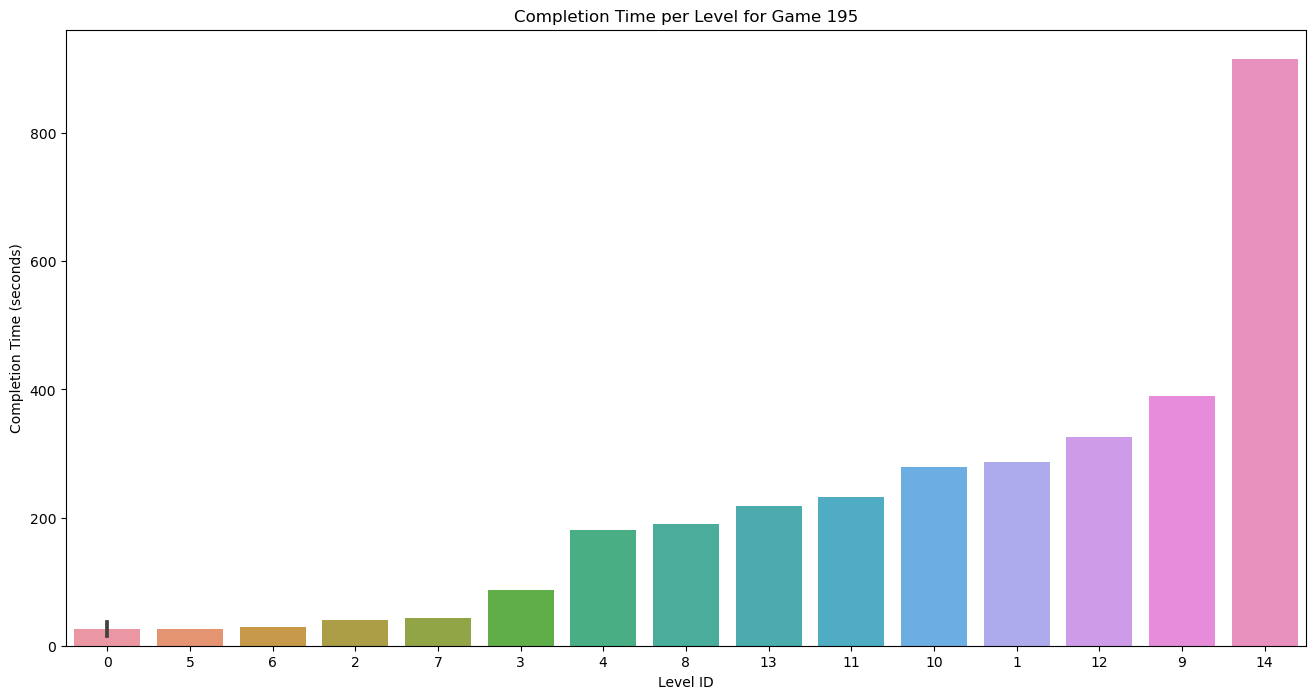

Total time for game 189: 54.98319625 minutes


In [13]:
# Player 189

levels_for_game_189 = completed_levels[completed_levels['game_id'] == 189].sort_values(by='completion_time', ascending=True)

plt.figure(figsize=(16, 8))
sns.barplot(x='level_id', y='completion_time', data=levels_for_game_189)
plt.xlabel('Level ID')
plt.ylabel('Completion Time (seconds)')
plt.title('Completion Time per Level for Game 195')
plt.show()

# print total time
print(f"Total time for game 189: {levels_for_game_189['completion_time'].sum() / 60.0} minutes")

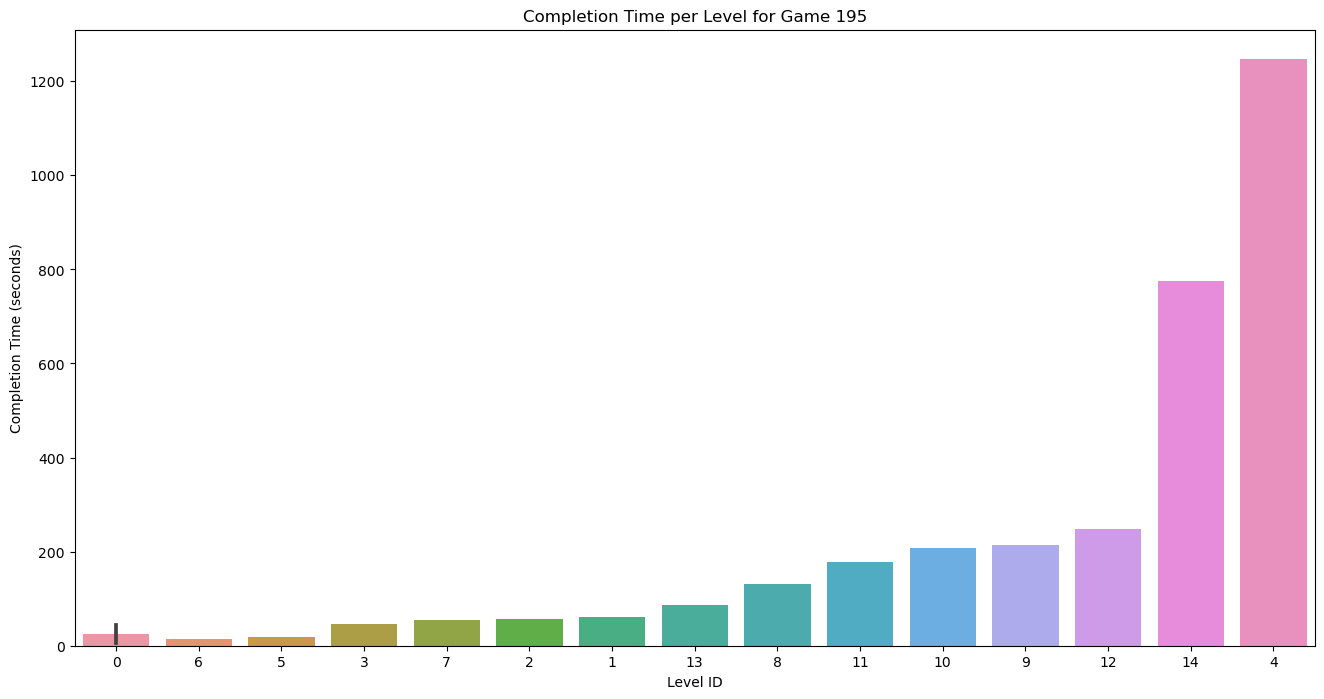

Total time for game 183: 56.50907945000001 minutes


In [14]:
# player 183

levels_for_game_183 = completed_levels[completed_levels['game_id'] == 183].sort_values(by='completion_time', ascending=True)

plt.figure(figsize=(16, 8))
sns.barplot(x='level_id', y='completion_time', data=levels_for_game_183)
plt.xlabel('Level ID')
plt.ylabel('Completion Time (seconds)')
plt.title('Completion Time per Level for Game 195')
plt.show()

# print total time
print(f"Total time for game 183: {levels_for_game_183['completion_time'].sum() / 60.0} minutes")

# Comparison to player robozzle scores

In [15]:
# pull in robozzle.csv
robozzle = pd.read_csv('sprint.csv')
robozzle = robozzle[['nationalid', 'selectionsprintxp', 'zzzlegamelastlevel']]
robozzle = robozzle.dropna(subset=['nationalid'])
robozzle = robozzle.sort_values(by='zzzlegamelastlevel', ascending=False).drop_duplicates(subset='nationalid', keep='first')


games_filtered = games_filtered.merge(robozzle, left_on='id_code', right_on='nationalid')

completed_levels['level_id'] = completed_levels['level_id'].astype(int)
completed_levels['sokoban_score'] = completed_levels['level_id'].apply(lambda x: level_weights[x])

df_scores = completed_levels.groupby('game_id')['sokoban_score'].sum().reset_index()
df_scores.rename(columns={'game_id': 'id'}, inplace=True)

df_games = pd.merge(games_filtered, df_scores, on='id', how='left')
df_games['sokoban_score'] = df_games['sokoban_score'].fillna(0)

# [1.1022727272727273, 2.9333333333333336, 2.0, 4.333333333333334, 7.142857142857142, 1.2325581395348837, 1.051282051282051, 1.6666666666666667, 3.5, 3.4, 3.0666666666666664, 5.857142857142857, 1.2727272727272727, 3.1176470588235294, 5.0]




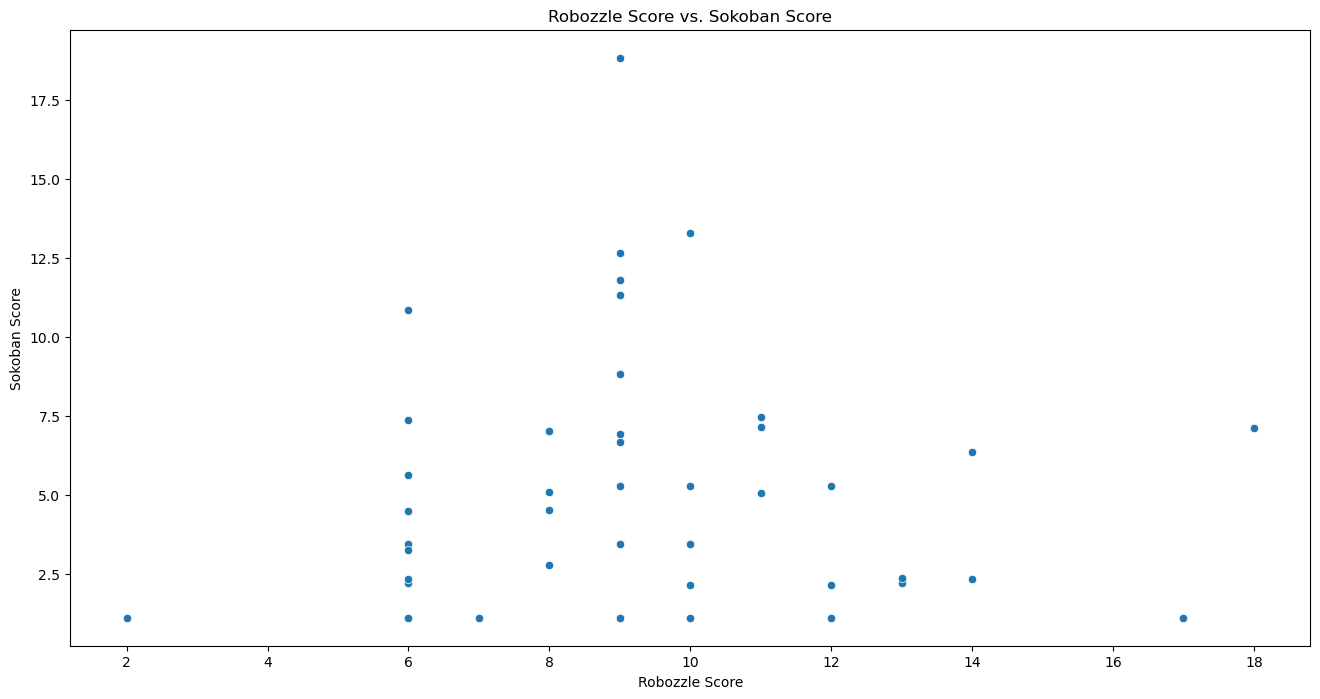

In [16]:
# plot zzzlegamelastlevel from df_games against sokoban_score

plt.figure(figsize=(16, 8))
sns.scatterplot(x='zzzlegamelastlevel', y='sokoban_score', data=df_games)
plt.xlabel('Robozzle Score')
plt.ylabel('Sokoban Score')
plt.title('Robozzle Score vs. Sokoban Score')
plt.show()


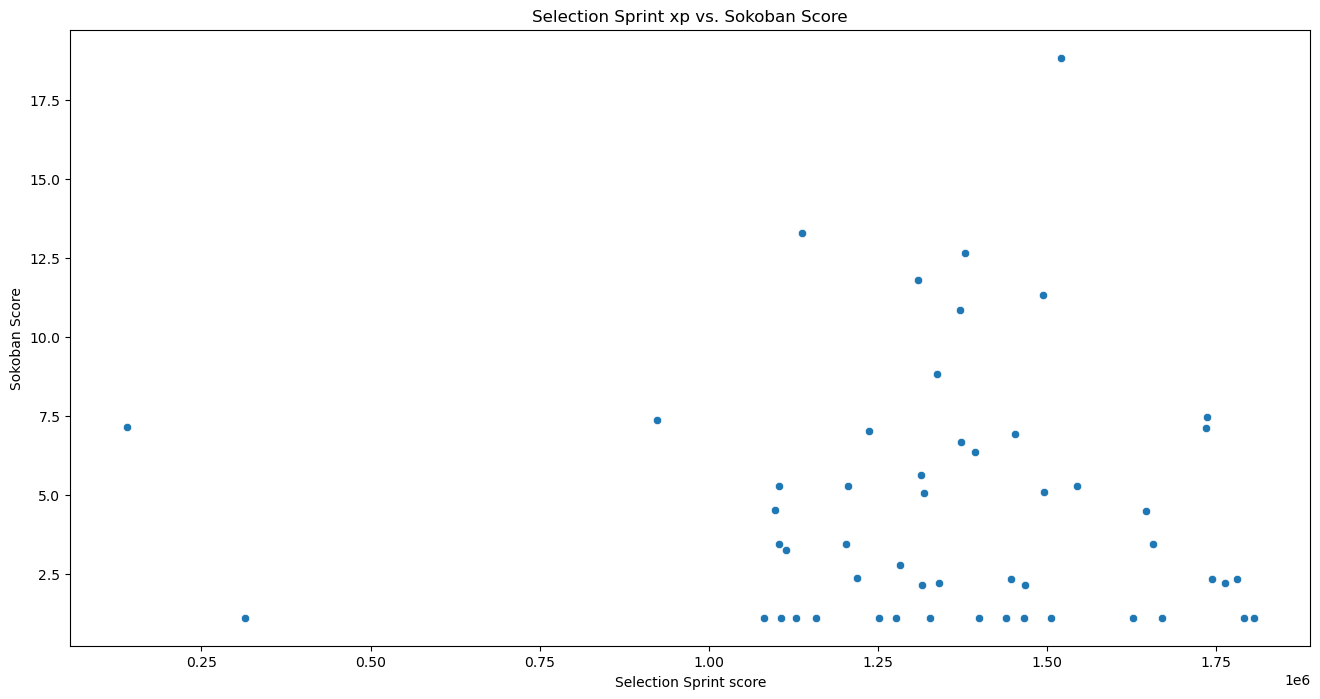

In [17]:
# # plot selectionsprintxp from df_games against sokoban_score

plt.figure(figsize=(16, 8))
sns.scatterplot(x='selectionsprintxp', y='sokoban_score', data=df_games)
plt.xlabel('Selection Sprint score')
plt.ylabel('Sokoban Score')
plt.title('Selection Sprint xp vs. Sokoban Score')
plt.show()

In [18]:
# Pearson correlation coefficient

print(f"Pearson correlation coefficient between Robozzle score and Sokoban score: {df_games['zzzlegamelastlevel'].corr(df_games['sokoban_score'])}")

print(f"Pearson correlation coefficient between Selection Sprint score and Sokoban score: {df_games['selectionsprintxp'].corr(df_games['sokoban_score'])}")


# Calclate spearman for both too

print(f"Spearman correlation coefficient between Robozzle score and Sokoban score: {df_games['zzzlegamelastlevel'].corr(df_games['sokoban_score'], method='spearman')}")
print(f"Spearman correlation coefficient between Selection Sprint score and Sokoban score: {df_games['selectionsprintxp'].corr(df_games['sokoban_score'], method='spearman')}")

Pearson correlation coefficient between Robozzle score and Sokoban score: 0.012140959308046788
Pearson correlation coefficient between Selection Sprint score and Sokoban score: -0.03953001543016689
Spearman correlation coefficient between Robozzle score and Sokoban score: 0.07550207276491872
Spearman correlation coefficient between Selection Sprint score and Sokoban score: -0.06769714869878145


# Takeaways

* The data gives a pretty good idea of level difficulty and how to order them.
* Success percentage for most of the levels is under 50%. Should we add more easy levels?
* Median completion time was around 1 minute for easy ones, 5 minutes for the medium difficulty and 10 for harder ones. However we need to take into account that skipping was allowed. So when we eliminate skipping more of the slower people are going to finish levels and the median time will go up considerably. Also currently many people played multiple times and that also brought median time down.
* Taking that into account, 10-12 total levels is probably enough for the final game (assuming 1-2 game attempts per student)
* 1/3 of people gave up after the intro level - game too hard? Too little incentive to make an effort? Probably the random hard levels in the beginning threw many people off. Would be nice to test on current students with ordered levels and success-based incentives.
* Remove some middle levels with similar success rates and replace with some easier ones that fit in time gaps we currently seem to have.
* Stronger player level time distribution was similar to overall with some minor differences. 
* There seems to be no correlation between sokoban and robozzle | sokoban and sprintxp. Probably has a lot to do with the way the first sokoban test was set up.
